In [1]:
import os
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import  ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from minisom import MiniSom
from sklearn.metrics import accuracy_score, f1_score
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Reading and processing dataset 

In [3]:
train_file = 'KDDTrain+.txt'
test_file = 'KDDTest+.txt'

In [4]:
# Original KDD dataset feature names obtained from 
# http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
# http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

# 1. specify the column names and read data
header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'success_pred']
data = pd.read_csv(train_file, names=header_names)
test_data = pd.read_csv(test_file, names=header_names)


<function matplotlib.pyplot.show(close=None, block=None)>

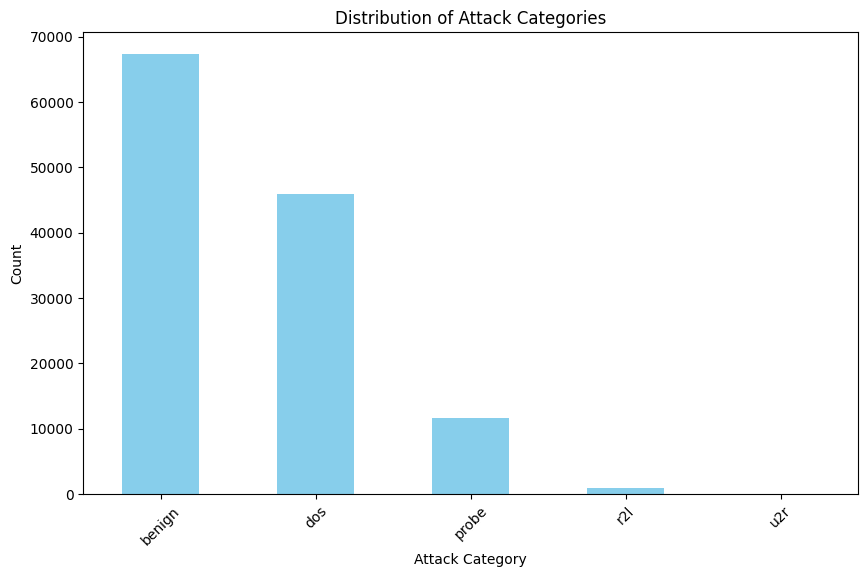

In [5]:
# 2. map the attack_type column to the five attack class labels
attack_mapping = {
    'apache2': 'dos', 'back': 'dos', 'mailbomb': 'dos', 'processtable': 'dos', 'snmpgetattack': 'dos',
    'teardrop': 'dos', 'smurf': 'dos', 'land': 'dos', 'neptune': 'dos', 'pod': 'dos', 'udpstorm': 'dos',
    'ps': 'u2r', 'buffer_overflow': 'u2r', 'perl': 'u2r', 'rootkit': 'u2r', 'loadmodule': 'u2r',
    'xterm': 'u2r', 'sqlattack': 'u2r', 'httptunnel': 'u2r',
    'ftp_write': 'r2l', 'guess_passwd': 'r2l', 'snmpguess': 'r2l', 'imap': 'r2l', 'spy': 'r2l',
    'warezclient': 'r2l', 'warezmaster': 'r2l', 'multihop': 'r2l', 'phf': 'r2l', 'named': 'r2l',
    'sendmail': 'r2l', 'xlock': 'r2l', 'xsnoop': 'r2l', 'worm': 'r2l',
    'nmap': 'probe', 'ipsweep': 'probe', 'portsweep': 'probe', 'satan': 'probe',
    'mscan': 'probe', 'saint': 'probe',
    'normal': 'benign'
}
data['attack_category'] = data['attack_type'].map(attack_mapping).fillna('benign')
test_data['attack_category'] = test_data['attack_type'].map(attack_mapping).fillna('benign')

# plot label distribution
category_counts = data['attack_category'].value_counts()

plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Attack Categories')
plt.xlabel('Attack Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show


In [6]:
# Feature engineering
X = data.drop(columns=['attack_type', 'success_pred', 'attack_category'])
y = data['attack_category']
y_mapped = y.map({'benign': 0, 'dos': 1, 'u2r': 2, 'r2l': 3, 'probe': 4})

categorical_cols = ['protocol_type', 'service', 'flag']
bin_cols = ['land', 'logged_in', 'is_host_login', 'is_guest_login']
numerical_cols = [col for col in X.columns if col not in categorical_cols + bin_cols]

# Data cleaning and feature processing
for col in numerical_cols:
    X[col] = pd.to_numeric(X[col], errors='coerce')
    X[col].fillna(X[col].median(), inplace=True)

# Normalize numerical features and one-hot encode discrete features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

X_processed = pipeline.fit_transform(X)

X_processed.shape


(125973, 122)

# Model Training

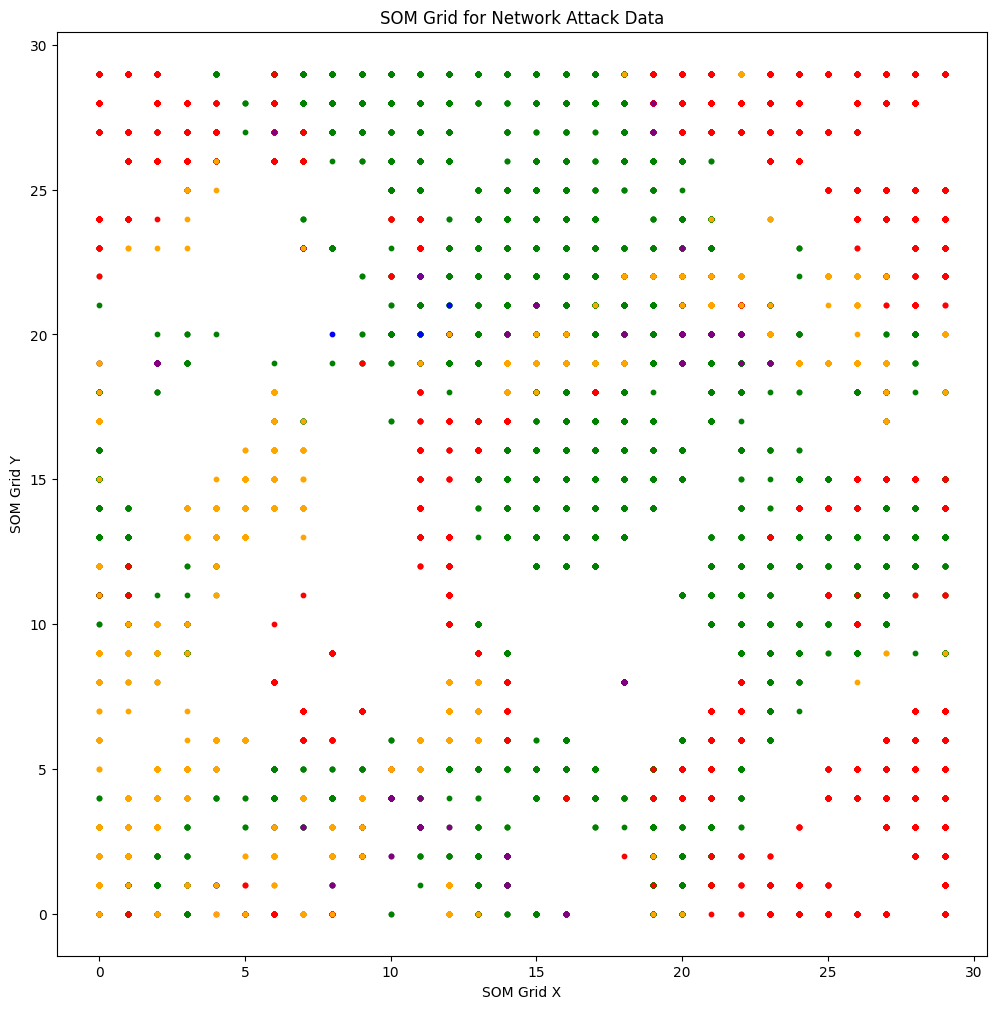

In [7]:
# SOM
som_x, som_y = 30, 30
som = MiniSom(x=som_x, y=som_y, input_len=X_processed.shape[1], sigma=4.0, learning_rate=0.1)

som.random_weights_init(X_processed)
som.train_random(data=X_processed, num_iteration=3000)

som_labels = np.array([som.winner(x) for x in X_processed])
label_count = defaultdict(list)

for i, label in enumerate(y_mapped):
    som_coord = tuple(som_labels[i])
    label_count[som_coord].append(label)

som_coord_to_label = {coord: max(set(labels), key=labels.count) for coord, labels in label_count.items()}

category_colors = {'benign': 'green', 'dos': 'red', 'u2r': 'blue', 'r2l': 'purple', 'probe': 'orange'}

plt.figure(figsize=(12, 12))
plt.title("SOM Grid for Network Attack Data")
for category in category_colors.keys():
    category_idx = (y == category)
    plt.scatter(som_labels[category_idx, 0], som_labels[category_idx, 1],
                c=category_colors[category], label=category, s=10)
plt.xlabel("SOM Grid X")
plt.ylabel("SOM Grid Y")
plt.show()


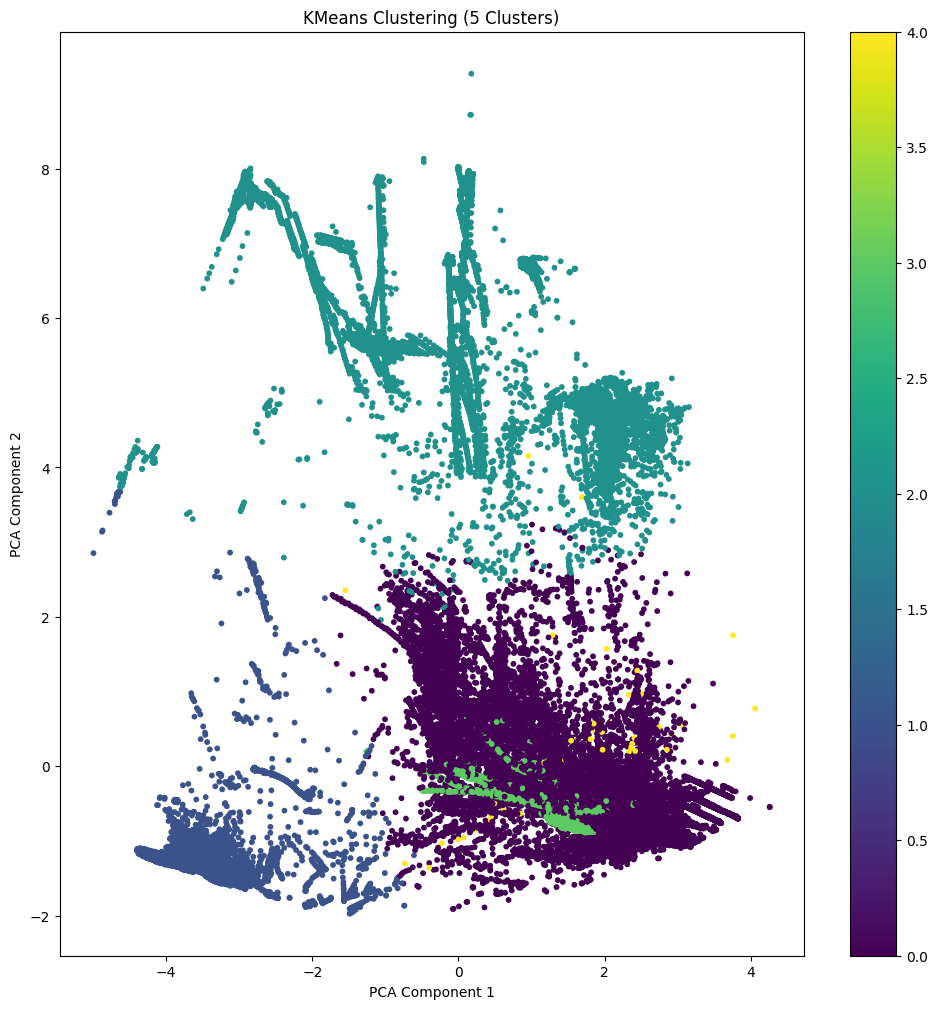

In [8]:
# KMeans
kmeans = KMeans(n_clusters=5, random_state=42, init='k-means++', max_iter=1000).fit(X_processed)
kmeans_labels = kmeans.predict(X_processed)

cluster_label_map = {}
for cluster in range(5):  # 假设有 5 个簇
    # 找出每个簇中对应的真实标签
    mask = (kmeans_labels == cluster)
    majority_label = y_mapped[mask].mode()[0]  # 计算多数标签
    cluster_label_map[cluster] = majority_label  # 将簇标签映射为主要标签

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_processed)

plt.figure(figsize=(12, 12))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeans_labels, cmap='viridis', s=10)
plt.colorbar()
plt.title("KMeans Clustering (5 Clusters)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


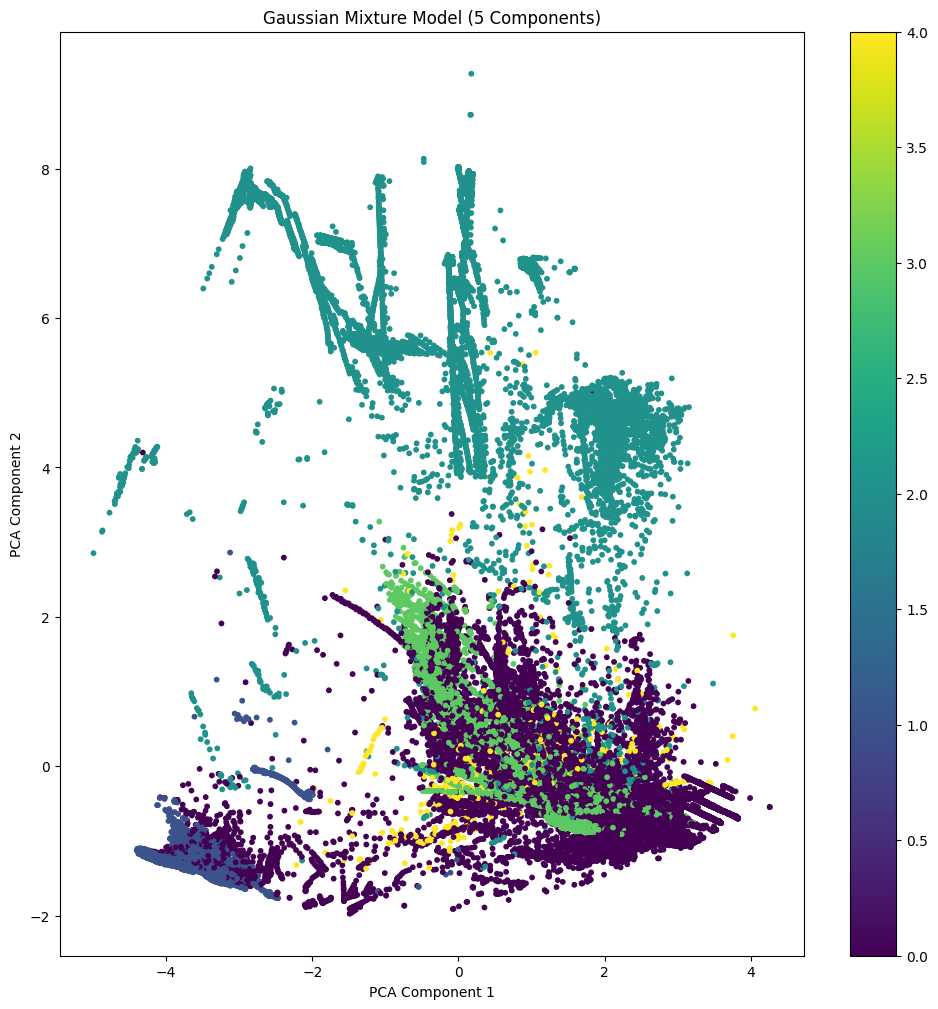

In [9]:
# GMM
gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=42, max_iter=1000)
gmm_labels = gmm.fit_predict(X_processed)
component_label_map = {}
for component in range(5):  # 假设有 5 个成分
    # 找出每个成分中对应的真实标签
    mask = (gmm_labels == component)
    majority_label = y_mapped[mask].mode()[0]  # 计算多数标签
    component_label_map[component] = majority_label  # 将成分标签映射为主要标签


plt.figure(figsize=(12, 12))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=gmm_labels, cmap='viridis', s=10)
plt.colorbar()
plt.title("Gaussian Mixture Model (5 Components)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


# Test set Experiments

In [10]:
test_data['attack_category'] = test_data['attack_type'].map(attack_mapping).fillna('benign')

X_test = test_data.drop(columns=['attack_type', 'success_pred', 'attack_category'])
y_test = test_data['attack_category']

for col in numerical_cols:
    X_test[col] = pd.to_numeric(X[col], errors='coerce')
    X_test[col].fillna(X[col].median(), inplace=True)

X_test_processed = pipeline.transform(X_test)

pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_processed)
y_test_mapped = y_test.map({'benign': 0, 'dos': 1, 'u2r': 2, 'r2l': 3, 'probe': 4})

print(X_test_processed.shape)


(22544, 122)


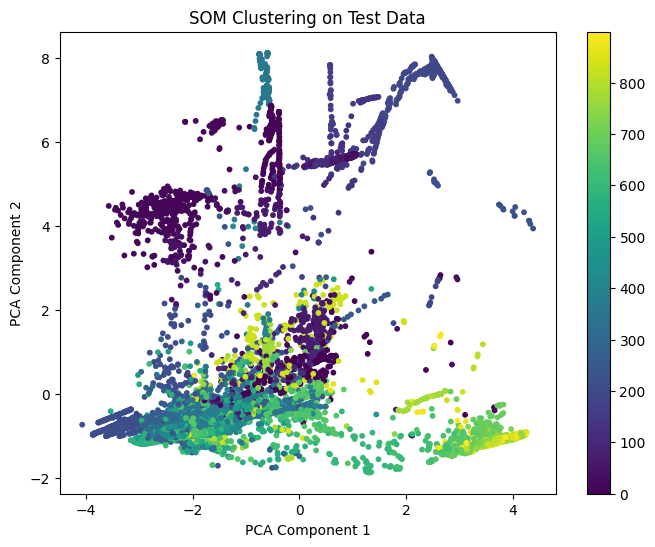

SOM Accuracy: 0.3321504613200852
SOM F1 Score: 0.34107743770248033


In [11]:
# SOM test
som_labels_test = np.array([som.winner(x) for x in X_test_processed])
som_predicted_labels = [som_coord_to_label.get(tuple(coord), -1) for coord in som_labels_test]
som_labels_flat_test = np.array([label[0] * som_y + label[1] for label in som_labels_test])

plt.figure(figsize=(8, 6))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=som_labels_flat_test, cmap='viridis', s=10)
plt.title("SOM Clustering on Test Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar()
plt.show()

# SOM 准确率和 F1 分数
accuracy_som = accuracy_score(y_test_mapped, som_predicted_labels)
f1_som = f1_score(y_test_mapped, som_predicted_labels, average='weighted')
print("SOM Accuracy:", accuracy_som)
print("SOM F1 Score:", f1_som)


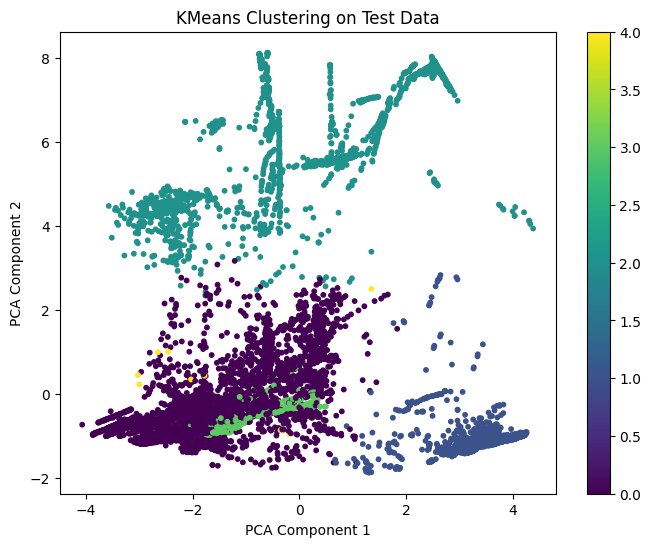

KMeans Accuracy: 0.3925656493967353
KMeans F1 Score: 0.33884936418177974


In [12]:
# Kmeans
kmeans_labels_test = kmeans.predict(X_test_processed)
mapped_test_labels = [cluster_label_map[label] for label in kmeans_labels_test]  # 使用映射的主要标签
plt.figure(figsize=(8, 6))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=kmeans_labels_test, cmap='viridis', s=10)
plt.title("KMeans Clustering on Test Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar()
plt.show()

# 计算 KMeans 的 Accuracy 和 F1 Score
accuracy_kmeans = accuracy_score(y_test_mapped, mapped_test_labels)
f1_kmeans = f1_score(y_test_mapped, mapped_test_labels, average='weighted')
print("KMeans Accuracy:", accuracy_kmeans)
print("KMeans F1 Score:", f1_kmeans)


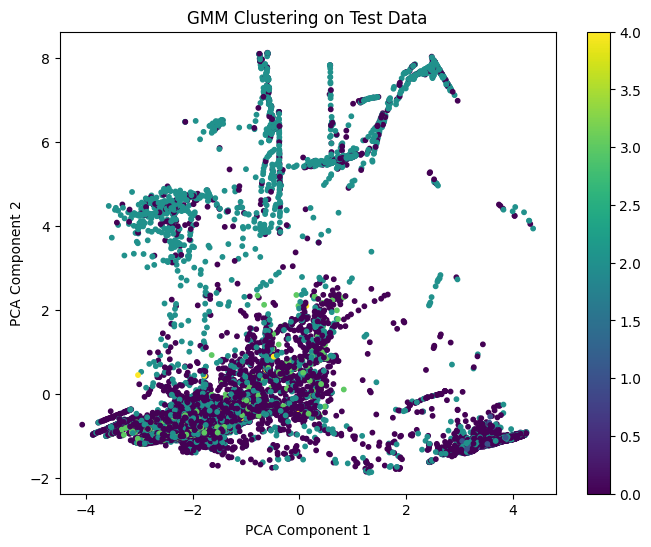

GMM Accuracy: 0.5885379701916252
GMM F1 Score: 0.5076400219905076


In [13]:
gmm_labels_test = gmm.predict(X_test_processed)
mapped_test_labels = [component_label_map[label] for label in gmm_labels_test]

plt.figure(figsize=(8, 6))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=gmm_labels_test, cmap='viridis', s=10)
plt.title("GMM Clustering on Test Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar()
plt.show()

# 计算 GMM 的 Accuracy 和 F1 Score
accuracy_gmm = accuracy_score(y_test_mapped, mapped_test_labels)
f1_gmm = f1_score(y_test_mapped, mapped_test_labels, average='weighted')
print("GMM Accuracy:", accuracy_gmm)
print("GMM F1 Score:", f1_gmm)

